# Sagemaker Ground Truth Object Detector One Shot Notebook
*Written by xavtidus@ with incredible help and input from (and a big thank you to): atlynch@, djenny@ and benhuan@.*
## Train your completed Ground Truth Object Detector labelling job in no time

### Why we made this notebook
The intention behind this notebook is to allow anyone to input the name of their Sagemaker Ground Truth Object Detector Labelling Job, and immediately be able to start training that model and consume it. We've attempted to take away all the complications behind finding the right prameter inputs and items of information needed that can be spread over a number of config and manifest files and build a tool that can determine them by crawling forward from the Sagemaker Ground Truth Object Detector Labelling Job's name.

If you're interested in the subject, you will be able to follow along below and see where the code is grabbing what information and where from. A lot of the time, code is easier to interpret than the instruction manual, and we hope that this is indeed the case here.

If you're just looking for a quick outcome, this notebook is also perfect for you. There are definitely performance improvements that could be made to your model's training, however this notebook will get you a workable outcome as long as the input imagery into your Sagemaker Ground Truth Object Detector job was good quality.

## A quick technical note

This notebook has to be executed on a SageMaker notebook instance. It will easily help you train a model straight from the completed output of a Sagemaker Ground Truth labelling job, with no prior knowledge required.

*If you are asked to choose a kernel for this notebook, choose "conda_mxnet_p36" or "MXNet 1.6 Python 3.6"*


## Step 1. Configurables

There is only one required configurable for this notebook, and that's the name of your Sagemaker Ground Truth Labelling Job which should be completed already. There are however, some optional configurables in the next cell should you wish to get a little adventurous.

In [1]:
sm_groundtruth_od_labelling_job_name = "awsdltv2FinalApproach"

# This script will automatically crawl this job for all the related manifest files to derrive 
# the remaining items of configuration about your training data, labels and S3 paths.


And here are the optional configurables should you wish to customise your training

In [2]:
training_epochs = 20
learning_rate = 0.001
training_instance_type='ml.p3.16xlarge'
training_instance_count = 1

That's it! From here on in, we will annotate code of interest with code comments for your information. Continue through all the steps to finish training your Sagemaker model.

## Step 2. Install depenencies and gather all required information

First we will install the dependencies needed

In [3]:
!pip install gluoncv==0.8.0
!pip install opencv-python

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


Now we will declare our imports

In [4]:
import sagemaker
import mxnet as mx
import matplotlib.pyplot as plt
import gluoncv as gcv
import glob
import math
import numpy as np
import json
import cv2
import os
import tarfile
import boto3
import re
import random
import string
from sagemaker.debugger import Rule, rule_configs
from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from gluoncv import model_zoo, data, utils
import boto3

We will determine the Sagemaker Service role

In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

Now it's time to start automatically resolving information such as the training data manifest, output ground truth annotations manifest, the class labels used in training and the label attribute name for the training job (not always the same as the name you gave the job when you created it)

In [6]:
#Create a SageMaker Boto3 client to do some lookups
sm_client = boto3.client('sagemaker')

#query the SM GT Labelling Job by Name
response = sm_client.describe_labeling_job(
    LabelingJobName=sm_groundtruth_od_labelling_job_name
)

sm_gt_manifest_file_s3_path = response["LabelingJobOutput"]["OutputDatasetS3Uri"]
sm_gt_source_frames_manifest_s3_path = response["InputConfig"]["DataSource"]["S3DataSource"]["ManifestS3Uri"]
sm_gt_label_category_config_s3_path = response["LabelCategoryConfigS3Uri"]

source_training_frames_s3_prefix = '/'.join(sm_gt_source_frames_manifest_s3_path.split('/')[:-1])
ground_truth_manifest_s3_prefix = '/'.join(sm_gt_manifest_file_s3_path.split('/')[:-1])

# define an s3 client for some s3 operations
s3_client = boto3.client('s3')

#let's grab the config json file that contains all our labels for this Ground Truth job and build our classes array
sm_gt_classes = []

_bucketName = sm_gt_label_category_config_s3_path.split('/')[2]
_keyPath = '/'.join(sm_gt_label_category_config_s3_path.split('/')[3:])
response = s3_client.get_object(
    Bucket=_bucketName,
    Key=_keyPath
)
_label_cfg_file = json.loads(response['Body'].read().decode('utf-8'))

for label in _label_cfg_file["labels"]:
    sm_gt_classes.append(label["label"])
            
#Now we need to grab the manifest file from S3 to determine the "Label Attribute Name" for this labelling job, as it can be different from what the name is in Ground Truth
_bucketName = sm_gt_manifest_file_s3_path.split('/')[2]
_keyPath = '/'.join(sm_gt_manifest_file_s3_path.split('/')[3:])
response = s3_client.get_object(
    Bucket=_bucketName,
    Key=_keyPath
)
manifest_file_body = response['Body'].read().decode('utf-8')
manifest_line_0 = manifest_file_body.split('\n')[0]
_m_obj = json.loads(manifest_line_0)

#We have now found the label attribute name for this manifest file.
labelAttributeName = list(_m_obj.keys())[1]


## Step 3. Preview labelling

We will grab the preview image from your training set and overlay the applicable detection regions found by your annotators to preview the datasets and make sure we're about to start training with the right data.

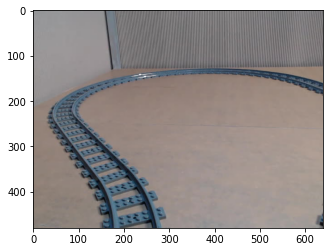

In [7]:
image_info = []

lines = manifest_file_body.strip().split('\n')
for line in lines:
    image_info.append(json.loads(line))

info = image_info[0]

class_map = info[f'{labelAttributeName}-metadata']['class-map']
img_bucket = info['source-ref'].split('/')[2]
img_filename = info['source-ref'].split('/')[-1]
img_s3_path = "/".join(info['source-ref'].split('/')[3:])

s3_client.download_file(img_bucket, img_s3_path, "source-ref/"+img_filename)

image = plt.imread(os.path.join("source-ref",img_filename))
saved_image = image.copy() #Save an unmanipulated reference to the image
boxes = info[labelAttributeName]['annotations']
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
plt.imshow(image)
plt.show()

## Step 4. Submit the training job to SageMaker

Last but not least, it's time to create our MXNet Estimator and submit the job for training with SageMaker. This may take quite a while to complete depending on the size of your training dataset and the selected instance type and scale of your training compute.

**This step may take a few minutes to a few hours to complete. Depending on the volume of data in your dataset and the number of epochs you have configured the training to undertake in Step 1.**

In [8]:
mxnet_estimator = MXNet(base_job_name=sm_groundtruth_od_labelling_job_name,
                        entry_point='estimator.py',
                        source_dir='entry_point',
                        role=role,
                        instance_type=training_instance_type,
                        instance_count=training_instance_count,
                        sagemaker_session=sagemaker_session,
                        framework_version='1.6.0', 
                        py_version='py3',
                        hyperparameters={
                            "task-name": labelAttributeName,
                            "classes-csv": ",".join(sm_gt_classes),
                            "target-epochs": training_epochs,
                            "learning-rate": learning_rate
                        })

mxnet_estimator.fit({'train': source_training_frames_s3_prefix, 'labels': ground_truth_manifest_s3_prefix})

2022-01-17 06:57:44 Starting - Starting the training job...
2022-01-17 06:57:58 Starting - Launching requested ML instancesProfilerReport-1642402664: InProgress
.........
2022-01-17 06:59:34 Starting - Preparing the instances for training.........
2022-01-17 07:01:11 Downloading - Downloading input data
2022-01-17 07:01:11 Training - Downloading the training image.........
2022-01-17 07:02:30 Training - Training image download completed. Training in progress.2022-01-17 07:02:30,173 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-01-17 07:02:30,253 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"classes-csv":"legotrain","learning-rate":0.001,"target-epochs":20,"task-name":"awsdltv2FinalApproach"}', 'SM_USER_ENTRY_POINT': 'estimator.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_i

## Step 5. Download and run your model locally / on your target device.

*Optionally, you can continue on and deploy a Sagemaker Inference Endpoint, which is a fully managed service that allows you to make real-time inferences via a REST API. Great for internet connected projects that have low grade compute which wouldn't otherwise be able to run its own inference models. This will also allow you to easily preview the model's predictive abilities against your training data.*

### Visit the AWS Console to download your newly trained model.
Be sure to double check the region the console is set to if you do not immediately see your model in the list.

In the [AWS Console, navigate to Amazon Sagemaker](https://console.aws.amazon.com/sagemaker/home), then in the left-hand menu expand "Training" and click "Training Jobs"


## Step 6. (Optional) Deploy an Amazon Sagemaker Inference Endpoint

This will enable you to deploy a fully managed service that allows you to make real-time inferences via a REST API. You will also get to see your model's predictions against 9 randomly selected images from your training dataset.

**This step may take a few minutes to complete**

In [9]:
#If you like, you can adjust the below parameter to a different compute instance type for your Inference Endpoint
sm_i_endpoint_instance_type = 'ml.m5.4xlarge'

#You can also change the initial amount of instances for your endpoint
sm_i_initial_instance_count = 1

#The code below will generate a endpoint name for you based on the values previously, but you can change it to something else if you like.
sm_i_endpoint_name = "%s-%s" % ( sm_groundtruth_od_labelling_job_name, ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(6)) )

predictor = mxnet_estimator.deploy(
            instance_type=sm_i_endpoint_instance_type, 
            initial_instance_count=sm_i_initial_instance_count,
            endpoint_name=sm_i_endpoint_name
)

----!

## Step 7. Testing your model using the Sagemaker Inference Endpoint
Let's test out our model with some of our images we used in training. 

First we need some code to load and fetch images from S3:

In [10]:
#Set our images working directory
images_working_dir = "test-images/"

In [11]:
def s3_fetch_image(s3_uri, working_dir):
    _bucket = s3_uri.split('/')[2]
    _filename = s3_uri.split('/')[-1]
    _s3_path = "/".join(s3_uri.split('/')[3:])
    
    if os.path.exists(working_dir) == False:
        os.makedirs(working_dir)
    
    s3_client.download_file(_bucket, _s3_path, working_dir+_filename)
    

Next we need some code that will draw boxes onto our image files to represent the detections of our model's inference.

In [12]:
def run_inference(working_dir, sm_endpoint_name):
    runtime = boto3.client('runtime.sagemaker')
    client = boto3.client('sagemaker')

    for endpoint in  client.list_endpoints()['Endpoints']:
        if endpoint["EndpointName"] == sm_endpoint_name:
            gluoncv_endpoint = endpoint

    eval_images = glob.glob(working_dir+"*")
    n_images = len(eval_images)
    cols = (int(math.sqrt(n_images)))*2

    fig = plt.figure(figsize = (20,5))
    imgs = []
    for n, (image) in enumerate(eval_images[:n_images]):
        orig_img = cv2.imread(image)
        orig_img = cv2.resize(orig_img, (512,512))
        img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        payload = json.dumps(img.tolist())
        response = runtime.invoke_endpoint(EndpointName = gluoncv_endpoint['EndpointName'],
                                           Body = payload)
        response_body = response['Body']
        result = json.loads(response_body.read().decode())
        [class_IDs, scores, bounding_boxes] = result

        bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
        ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], class_IDs[0], thresh=0.6, class_names=sm_gt_classes)

        imgs.append(orig_img)   

    w = 10
    h = 10
    fig = plt.figure(figsize = (50, 50))
    columns = 3
    rows = 3
    for i in range(1, ( columns * rows ) +1 ):
        fig.add_subplot(rows, columns, i)
        plt.imshow(cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB))
    plt.show()

Now let's grab 9 random shots from our training manifest and see what our model finds within them.

**Note: you can re-run this cell to preview another 9 randomly selected images from you test dataset**

<Figure size 1440x360 with 0 Axes>

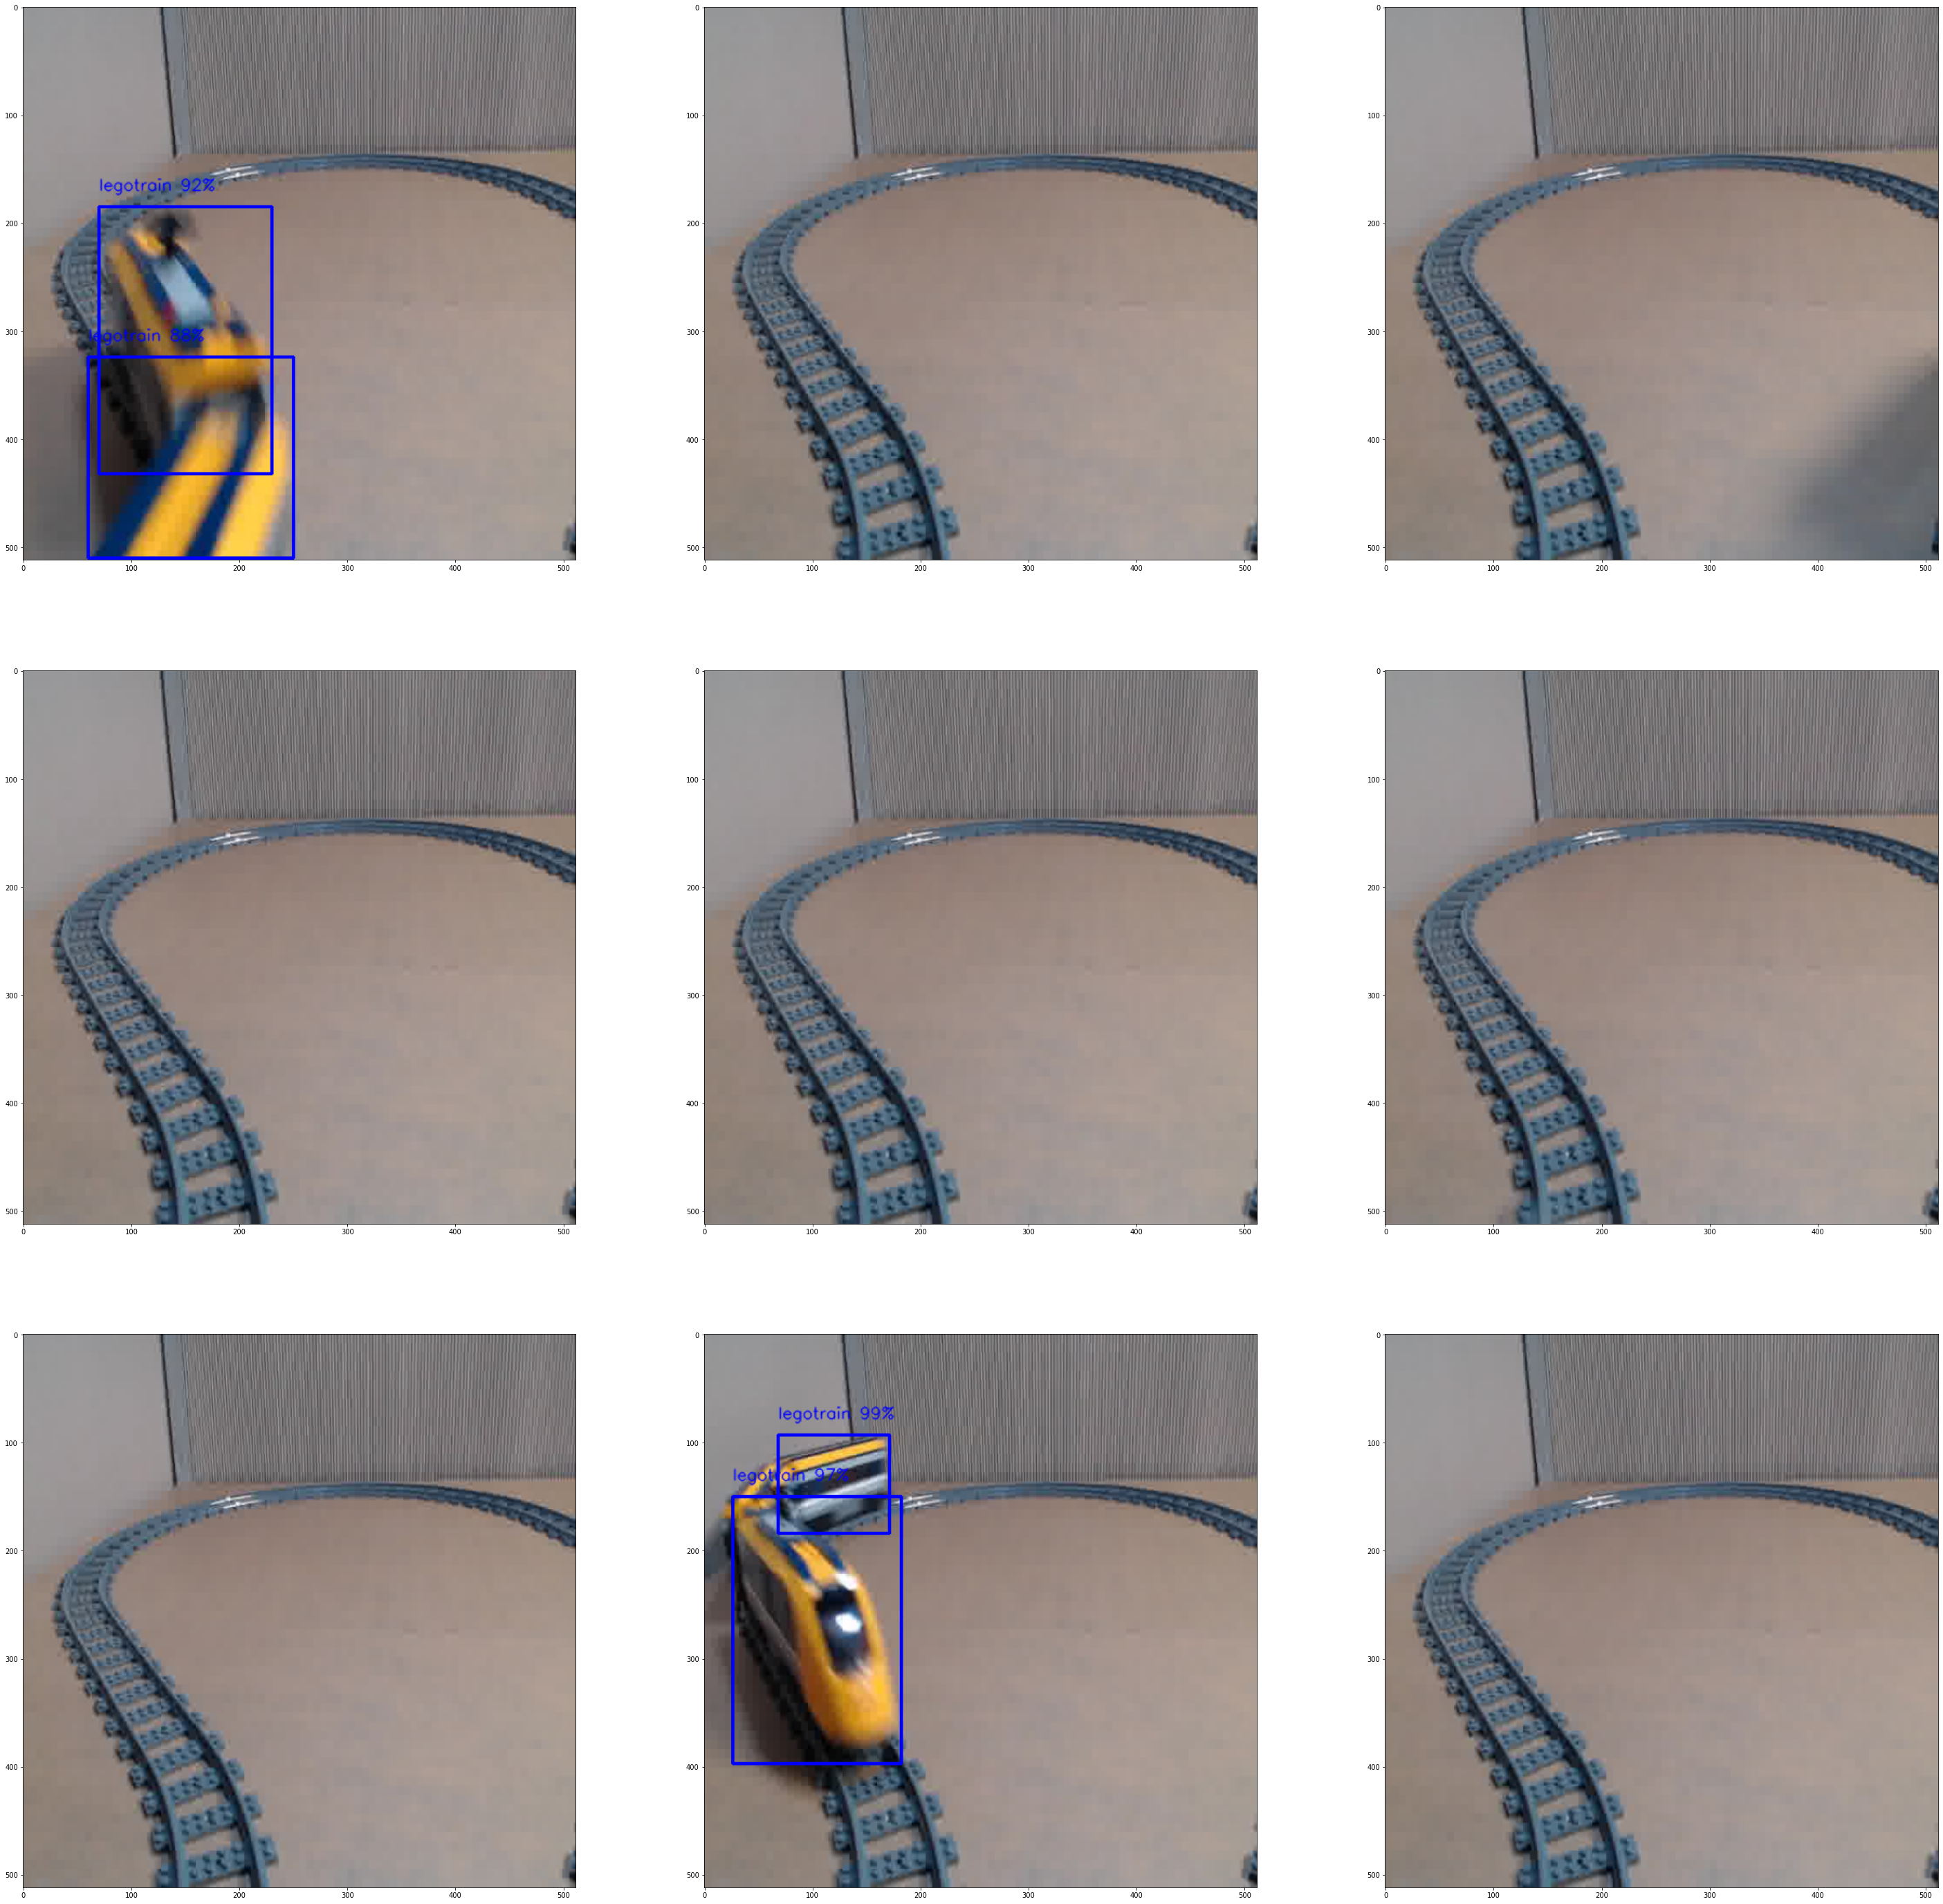

In [14]:
#First empty our images folder
if os.path.exists(images_working_dir): #if it doesn't yet exist, the downloader function will create it
    for file in glob.glob(images_working_dir+"*"):
        os.remove(file)

#Next, grab our training items
training_set_items = manifest_file_body.strip().split('\n')

#Then grab a random sample of training images
random_sample_set = random.sample(training_set_items, 9)

#download each file into our working dir
for sample in random_sample_set:
    s3_fetch_image(json.loads(sample)["source-ref"], images_working_dir)
    
run_inference(images_working_dir, sm_i_endpoint_name)


### Step 8. Terminating the Amazon Sagemaker Inference Endpoint
When you're done with your experiment, you can terminate your endpoint to save on usage costs by running the command below.

In [15]:
# Deletes the endpoint with the name set in the previous code cell
sagemaker.Session().delete_endpoint(sm_i_endpoint_name)